## Classification

This Python notebook ilustrates some concepts related of precision and recall in classification using MNIST dataset from Scikit-Learn.

First, we need to import MNIST dataset.

In [7]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

(70000, 784)

Now, let's check for X and y shape of the MNIST data. There are 70,000 images and each image has 784 features (28x28 pixels).

In [10]:
X.shape

(70000, 784)

In [11]:
y.shape

(70000,)

Let's peek at one digit from the dataset and display it using Matplotlib.

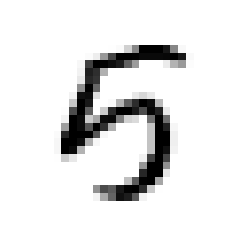

In [30]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[27000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

Let's check for the label of this random digit.

In [31]:
y[27000]

'5'

We will create a classification system using MNIST. Let's create the train set and the test set. The MNIST dataset is already split into a training set (the first 60,000 images) and a test set (the last 10,000 images).

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let's now shuffle the training set.

In [19]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

Let's try to identify one digit. Let's create a "5-detector" capable of distinguishing between just two classes, 5 and not-5. Let's create the target vectors.

In [23]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

We will now pick a classifier and train it. Let's pick a Stochastic Gradient Descent (SGD) classifier.

In [24]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use the classifier to detect images of the number 5.

In [32]:
sgd_clf.predict([some_digit])

array([ True])

## Evaluating Model's Performance

There are many performance measures available. Let's first measure the accuracy of the model using cross-validation.

In [34]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95885, 0.9673 , 0.9156 ])

The cv=3 means we wanto to use K-fold cross-validation with three folds. Each fold contain a representative ratio of each class. K-fold means splitting the training set into K-folds (three in this case), then make predictions and evaluating them on each fold using a model trained on the remaining folds.

We saw that even with a basic classifier we got above 90% accuracy.

If we create a dumb classifier that just classifies every image in the "non-5" class we will have over 90% accuracy too.

In [35]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [37]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9082 , 0.9099 , 0.91085])

Only about 10% of the images are 5s, so if we always guess that an image is not a 5, we will be right about 90% of the time !

This demonstrates why accuracy is generally not the preferred performance measure for classifiers.

## Confusion Matrix

A better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as B. For example, to know the number of times the classifier confused images of 5s with 3s, we will look in the 5th row and 3rd column of the confusion matrix.

To compute the confusion matrix we first need to have a set of predictions so they can be compared to the actual targets.

In [39]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Let's create the confusion matrix passing the target classes (y_train_5) and the predicted classes (y_train_pred).

In [40]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52401,  2178],
       [  987,  4434]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

| Actual Class            | Predicted Negative  | Predicted Positive  |
|-------------------------|---------------------|---------------------|
| Negative Class (non-5s) | True Negative (TN)  | False Positive (FP) |
| Positive Class (5s)     | False Negative (FN) | True Positive (TP)  |

* TN - non-5 images correctly classified as non-5s
* FP - non-5 images classified as 5s
* FN - 5 images wrongly classified as non-5s
* TP - 5 images correctly classified as 5

The confusion matrix gives us a lot of information but sometimes we may use a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the *precision* of the classifier.

$ precision = \frac{TP}{TP + FP} $

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision 1/1 = 100%). So precision is typically used along with another metric named *recall*, also called *sensitivity* or *true positive rate* (TPR): this is <u>the ratio of positive instances that are correctly detected by the classifier</u>.

$ recall = \frac{TP}{TP + FN} $

Let's use Scikit-Learn functions to compute precision and recall metrics.

In [41]:
from sklearn.metrics import precision_score, recall_score

In [42]:
precision_score(y_train_5, y_train_pred)

0.6705989110707804

In [43]:
recall_score(y_train_5, y_train_pred)

0.8179302711676812

Now the classifier does not look as shiny as it did when we look at the accuracy. When it claims an image represents a 5, it is correct 67% of the time. Moreover, it only detects 82% of the 5s.

It is often convenient to combine precision and recall into a single metric called *the F<sub>1</sub> score*. The F<sub>1</sub> score is the harmonic mean of the precision and recall.

$ F_{1} = \frac{TP}{TP + \frac{FN + FP}{2}} $

Let's compute the F<sub>1</sub> score using Scikit-Learn.

In [44]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7369733233607579

F<sub>1</sub> score favors classifiers that have similar precision and recall. In some contexts we mostly care about precision, and others recall.

For example, if we train a classifier to detect videos that are safe for kids we will probably prefer a classifier that reject good videos (low recall) but keeps only safe ones (high precision). On the ther hand, suppose we train a classifier to detect shoplifters on survaillance images: it is probably fine if our classifier has only 30% precision as long as it has 99% recall (the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, we can't have it both ways: increasing precision reduces recall, and vice versa. This is called the *precision/recall tradeoff*.